# TFP Probabilistic Layers: Variational Auto Encoder

2019 년 발표된 TensorFlow Probability(TFP) 레이어를 사용하여 간단하게 VAE(Variational Autoencoder)를 만듭니다.

TFP 레이어는 Keras를 사용하여 심층 네트워크로 배포를 구성하기 위한 high-level API를 제공합니다. 이 API를 사용하면 딥러닝과 확률 프로그래밍을 결합한 모델을 쉽게 구축할 수 있습니다. 예를 들어, 심층 네트워크의 출력으로 확률 분포를 매개변수화할 수 있습니다.   

### Variational Autoencoder와 ELBO
VAE(Variational Autoencoder)는 collaborative filtering, 이미지 압축, 강화 학습, 음악 및 스케치 생성 등 다양한 영역에서 사용되는 인기 있는 생성 모델입니다.  

MNIST 같은 숫자를 그리는 과정에서 우리는 잠재 변수 생성 모델과 같이 데이터를 생성하는 일부 프로세스를 머리 속으로 상상합니다. 숫자를 그리기 전에 먼저 그릴 숫자를 결정하고 머릿속에 흐릿한 그림을 상상한다고 가정해 보겠습니다. 그런 다음 종이에 펜을 대고 실제 세계에서 그림을 만들어 봅니다. 이 두 단계 프로세스를  다음과 같이 공식화할 수 있습니다.  

1. 어떤 사전 분포 z ~ p(z)에서 어떤 잠재 표현 z를 샘플링합니다. 이것은 당신의 머리에 있는 흐릿한 그림입니다. "3"이라고 가정해 봅시다.  
2. 샘플을 기반으로 확률적 프로세스 x ~ p(x|z)로 모델링된 실제 그림 표현 x를 그립니다. 이렇게 하면 "3"을 쓸 때마다 조금씩 다르게 보입니다.  

손으로 글자를 쓸 때 같은 사람이 그려도 조금씩 달라지는 원인의 일부는 MNIST 숫자의 클래스 고유의 신호에 기인하고 다른 일부는 노이즈로 인한 것입니다. VAE는 두 프로세스의 명시적 모델을 사용하여 노이즈에서 신호를 분리하려는 시도입니다.  

이 목표를 훈련하기 위해 ELBO(Evidence Lower BOund) 목적함수를 최대화합니다.  

$$ELBO(x)=\int{dz}q(z|x)log{p(x|z)} + \int{dz}q(z|x)log{\frac{q(z|x)}{p(z)}}$$

여기서 3 가지 확률 밀도 함수는;
- $p(z)$ - 잠재 표현 z 의 prior  
- $q(z|x)$ - variational encoder  
- $p(x|z)$ - decoder (잠재 표현 z가 주어질 때 image x 의 가능도)  

ELBO는 관찰된 데이터 포인트의 로그 확률인 $log{p(x)}$의 하한입니다. ELBO 방정식의 첫 번째 적분은 재구성 항입니다. 그것은 우리가 이미지 x에서 시작하여 z로 인코딩하고 디코딩하고 원래 x를 다시 가져올 가능성을 묻습니다. 두 번째 항은 KL Divergence 항입니다. 인코더와 prior가 얼마나 가까운지를 측정합니다. 이 항은 인코더를 정직하게 유지하려는 것으로 생각할 수 있습니다. 인코더가 prior에 전혀 있을 것 같지 않은 z개의 샘플을 생성하는 경우 object는 prior와 비슷한 z개의 샘플을 생성하는 경우보다 나쁩니다. 따라서 인코더는 비용이 재구성 항의 이점보다 더 큰 경우에만 prior와 달라야 합니다.

### Code
위의 설명에 따라 세 가지 다른 구성 요소를 개별적으로 모델링하는 것이 타당하다는 것을 알 수 있습니다.   

Pior - $p(z)$   
Autoencoder - $q(z|x)$  
Decoder - $p(x|z)$

In [1]:
#!pip install tensorflow_datasets

In [2]:
import numpy as np
import seaborn as sns
import time
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Conv2D, Flatten, Dense, \
                                                         Lambda, Reshape, Conv2DTranspose
tfd = tfp.distributions
tfpl = tfp.layers

### Load Dataset

In [3]:
datasets, datasets_info = tfds.load(name='mnist',
                                    with_info=True,
                                    as_supervised=False)

def _preprocess(sample):
    image = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
    image = image < tf.random.uniform(tf.shape(image))   # Randomly binarize.
    return image, image

train_dataset = (datasets['train']
                 .map(_preprocess)
                 .batch(256)
                 .prefetch(tf.data.experimental.AUTOTUNE)
                 .shuffle(int(10e3)))
test_dataset = (datasets['test']
                .map(_preprocess)
                .batch(256)
                .prefetch(tf.data.experimental.AUTOTUNE))

위의 _preprocess()는 Keras가 (example, label) 입력 형식 (예 : $p_\theta(y|x)$)을 사용하는 discriminative model 용으로 설정되었기 때문에 `image`가 아닌 `image, image`를 반환합니다. VAE의 목표는 x 자체 (예 : $p_\theta(x|x)$)에서 입력 x를 복구하는 것이므로 데이터 쌍은 (example, example)입니다.

In [4]:
train_dataset, test_dataset

(<ShuffleDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.bool, name=None), TensorSpec(shape=(None, 28, 28, 1), dtype=tf.bool, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.bool, name=None), TensorSpec(shape=(None, 28, 28, 1), dtype=tf.bool, name=None))>)

### VAE Code

### Prior - latent representation z 은 isotropic Gaussian (등방성 가우시안 분포) 로 가정 

- Covariance가 identity matrix의 scala 배

In [5]:
encoded_size = 16
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                                     reinterpreted_batch_ndims=1)

- prior 의 분포 시각화

In [6]:
# ind = tfd.Independent(
#     distribution=tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
#     reinterpreted_batch_ndims=1)

# print(ind.mean(), ind.stddev())

# # 2d 구형 Gaussian 의 approximate density contour 를 plot
# N = 1000
# x = ind.sample(N)
# print(x.shape)

# x1 = x[:, 0]
# x2 = x[:, 1]
# sns.jointplot(x=x1, y=x2, kind = 'kde', space = 0)

- 공분산 행렬 시각화

In [7]:
# mu = [0., 0.]  # mean
# scale_tril = [[1.,  0.], [0.6, 0.8]]  # covariance
# tril = tfd.MultivariateNormalTriL(loc = mu, scale_tril = scale_tril)
# print(tril.mean(), tril.covariance())

# x = tril.sample(N)
# x1 = x[:, 0]
# x2 = x[:, 1]
# sns.jointplot(x=x1, y=x2, kind = 'kde', space = 0, color = 'r')

## Encoder
인코더 분포의 경우 신경망의 출력으로 매개 변수화된 평균 및 공분산 행렬과 함께 완전 공분산 가우스 분포를 사용합니다. 복잡하게 들릴 수 있지만 TFP 레이어로 표현하는 것은 매우 쉽습니다.  

인코더는 컨볼루션과 Dense 레이어로 구성된 일반적인 Keras Sequential 모델일 뿐 이지만 출력은 TFP 레이어인 MultivariateNormalTril()로 전달되어 최종 Dense() 레이어의 activaton을 mean 과 Multivariate Normal의 parameter인 (하삼각형) covariance matrix를 둘 다 지정하는데 필요한 부분으로 명확히 분할합니다.   
`tfpl.MultivariateNormalTriL.params_size(encoded_size)`를 Dense() layer output을 정확히 만들기 위해 사용합니다.

마지막으로 우리는 분포가 최종 손실에 "정규화" 항을 제공해야 한다고 말했습니다. 특히, encoder와 loss 에 대한 prior 사이에 KL Divergence를 추가합니다. ELBO의 KL 항 입니다. 

In [8]:
input_shape = datasets_info.features['image'].shape
input_shape

(28, 28, 1)

In [9]:
base_depth = 32

encoder = tf.keras.Sequential([
    InputLayer(input_shape=input_shape),
    Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    Conv2D(base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    Conv2D(base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    Conv2D(2 * base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    Conv2D(2 * base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    Conv2D(4 * encoded_size, 7, strides=1,
                padding='valid', activation=tf.nn.leaky_relu),
    Flatten(),
    Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
               activation=None),  
    tfpl.MultivariateNormalTriL(
        encoded_size,
        activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
])

In [10]:
tfpl.MultivariateNormalTriL.params_size(encoded_size)

152

## Decoder
단순한 `mean-field-decoder`를 사용합니다. 이 경우 pixel-dependent한 Bernoulli 분포 입니다.

In [11]:
decoder = tf.keras.Sequential([
    InputLayer(input_shape=[encoded_size]),
    Reshape([1, 1, encoded_size]),
    Conv2DTranspose(2 * base_depth, 7, strides=1,
                         padding='valid', activation=tf.nn.leaky_relu),
    Conv2DTranspose(2 * base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    Conv2DTranspose(2 * base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    Conv2DTranspose(base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    Conv2D(filters=1, kernel_size=5, strides=1,
                padding='same', activation=None),
    Flatten(),
    tfpl.IndependentBernoulli(input_shape, tfd.Bernoulli.logits),
])

In [12]:
vae = tf.keras.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]))

## Loss

이미 KL 항이 loss 에 더해졌으므로 reconstruction error 만 지정하면 됩니다. (ELBO 의 첫번째 항)

loss function 은 original input x 와 model 의 output 두개의 인수를 받습니다. random variable이므로 rv_x로 부릅니다. keras와 tensorflow가 TFP layer를 출력 tensor로 보더라도, TFP layer는 실제로는 Distribution object 입니다. 따라서, loss function을 주어진 model에서 data 의 negative log likelihood (-rv_x.log_prob(x))로 만들 수 있습니다. 

In [13]:
s = time.time()

negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negative_log_likelihood)

_ = vae.fit(train_dataset,
            epochs=30,
            validation_data=test_dataset)

Epoch 1/30
235/235 [==============================] - 35s 44ms/step - loss: 203.3555 - val_loss: 158.9863
Epoch 2/30
235/235 [==============================] - 13s 37ms/step - loss: 150.3750 - val_loss: 143.4304
Epoch 3/30
235/235 [==============================] - 13s 38ms/step - loss: 140.0791 - val_loss: 136.4566
Epoch 4/30
235/235 [==============================] - 13s 38ms/step - loss: 134.3950 - val_loss: 132.2134
Epoch 5/30
235/235 [==============================] - 13s 39ms/step - loss: 130.5199 - val_loss: 128.4751
Epoch 6/30
235/235 [==============================] - 13s 37ms/step - loss: 128.3064 - val_loss: 126.7067
Epoch 7/30
235/235 [==============================] - 13s 38ms/step - loss: 126.4891 - val_loss: 124.2740
Epoch 8/30
235/235 [==============================] - 13s 37ms/step - loss: 124.4144 - val_loss: 122.3950
Epoch 9/30
235/235 [==============================] - 13s 38ms/step - loss: 122.9773 - val_loss: 121.7341
Epoch 10/30
235/235 [=========================

In [14]:
print("Colab 소요 시간(분) : ", (time.time() - s) / 60)

Colab 소요 시간(분) :  9.032832026481628


## original image 를 vae network 을 통과시켜 얻은 distribution object 로 image sampling

In [15]:
#무작위 숫자 10개만 조사하겠습니다.
x = next(iter(test_dataset))[0][:10]
xhat = vae(x)
print(x.shape)
assert isinstance(xhat, tfd.Distribution)
print(xhat)

(10, 28, 28, 1)
tfp.distributions._TensorCoercible("tensor_coercible", batch_shape=[10], event_shape=[28, 28, 1], dtype=float32)


시각화 도우미 함수

In [16]:
import matplotlib.pyplot as plt

def display_imgs(x, y=None):
    if not isinstance(x, (np.ndarray, np.generic)):
        x = np.array(x)
    n = x.shape[0]
    fig, axs = plt.subplots(1, n, figsize=(n, 1))
    if y is not None:
        fig.suptitle(np.argmax(y, axis=1))
    for i in range(n):
        axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
        axs.flat[i].axis('off')
    plt.show()
    plt.close()
    plt.ion()

In [17]:
xhat.sample().shape, xhat.mode().shape, xhat.mean().shape

(TensorShape([10, 28, 28, 1]),
 TensorShape([10, 28, 28, 1]),
 TensorShape([10, 28, 28, 1]))

무작위로 고른 Original Image:


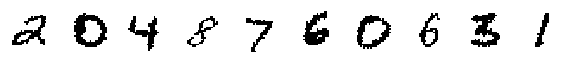

Decoded 분포에서 무작위 sample:


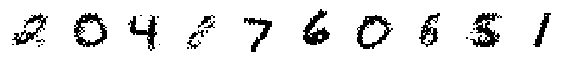

Decoded 분포의 최빈값:


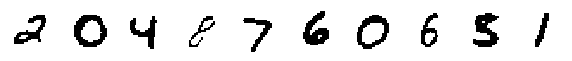

Decoded 분포의 평균값:


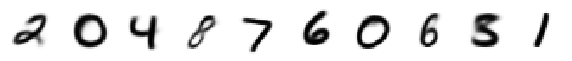

In [18]:
print('무작위로 고른 Original Image:')
display_imgs(x)

print('Decoded 분포에서 무작위 sample:')
display_imgs(xhat.sample())

print('Decoded 분포의 최빈값:')
display_imgs(xhat.mode())

print('Decoded 분포의 평균값:')
display_imgs(xhat.mean())

## original image 가 아니라 prior 에서 sampling 한 latent variable 로 image 생성

In [19]:
z = prior.sample(10)
xtilde = decoder(z)
print(xtilde)
assert isinstance(xtilde, tfd.Distribution)

tfp.distributions._TensorCoercible("tensor_coercible", batch_shape=[10], event_shape=[28, 28, 1], dtype=float32)


Randomly Generated Samples:


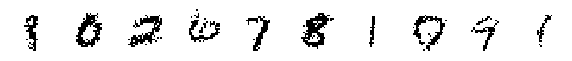

Randomly Generated Modes:


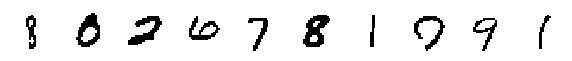

Randomly Generated Means:


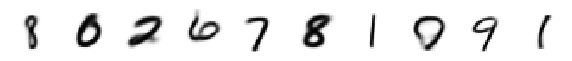

In [20]:
print('Randomly Generated Samples:')
display_imgs(xtilde.sample())

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())

###  latent variable 시각화

In [21]:
z = encoder(x)

In [22]:
latent = z.sample()
latent.shape

TensorShape([10, 16])

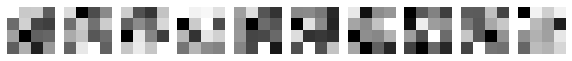

In [23]:
fig, axs = plt.subplots(1, 10, figsize=(10, 1))
plt.ioff()
for i in range(10):
    axs.flat[i].imshow(latent[i].numpy().reshape(4, 4), interpolation='none', cmap='gray')
    axs.flat[i].axis('off')
plt.show()